In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importamos las librerías necesarias**

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### **Cargamos el conjunto de datos con las interacciones entre genes**

In [ ]:
# Leemos el archivo CSV con las interacciones reducidas
interactions_df = pd.read_csv('drive/MyDrive/TFM/GeneRIF/interactions_human_reduced.csv')

# Seleccionamos las columnas 'gene_id' y 'interactant_id', eliminamos duplicados y ordenamos
interactions_df = interactions_df[['gene_id', 'interactant_id']].drop_duplicates().sort_values(by=['gene_id', 'interactant_id'])

# Filtramos las interacciones para eliminar aquellas donde un gen interactúa consigo mismo
interactions_df = interactions_df.loc[interactions_df['gene_id'] != interactions_df['interactant_id']]

# Creamos un diccionario para mapear los IDs numéricos a identificadores textuales
id_symbol_df = pd.read_csv('drive/MyDrive/TFM/id_symbol.csv')
id_to_symbol = id_symbol_df.set_index('id')['Symbol'].to_dict()

# Reemplazamos los identificadores numéricos por identificadores textuales en el dataframe de interacciones
interactions_df['gene1'] = interactions_df['gene_id'].map(id_to_symbol)
interactions_df['gene2'] = interactions_df['interactant_id'].map(id_to_symbol)

### **Preparamos los grafos resultantes de la reducción por varios métodos**

Contar con una versión reducida de un grafo que permita aglomerar a los nodos en comunidades es crucial para la comprensión y el análisis de redes complejas. Estas técnicas de reducción facilitan la identificación de patrones y estructuras subyacentes al simplificar la visualización de grandes volúmenes de datos. Al agrupar nodos en comunidades, se pueden detectar relaciones y comportamientos colectivos que podrían pasar desapercibidos en un grafo completo y detallado, permitiendo a los investigadores y analistas optimizar la toma de decisiones y el desarrollo de estrategias basadas en la estructura de la red.

In [ ]:
infomap_df = pd.read_csv('drive/MyDrive/TFM/interacciones_grafo_infomap.txt', header=None, names=['Gene'])
lpa_df = pd.read_csv('drive/MyDrive/TFM/interacciones_grafo_LPA.txt', header=None, names=['Gene'])
louvain_df = pd.read_csv('drive/MyDrive/TFM/interacciones_grafo_Louvain.txt', header=None, names=['Gene'])

In [ ]:
def visualize_graph(communities_df):

  # Preparamos los datos de las comunidades
  communities_df['Gene'] = communities_df['Gene'].str.split()
  communities_expanded = communities_df.explode('Gene')
  communities_expanded['Community'] = communities_expanded.index

  # Mapeamos los genes a las comunidades
  gene_to_community = communities_expanded.set_index('Gene')['Community'].to_dict()

  # Creamos un grafo vacío
  G = nx.Graph()

  # Añadimos las aristas y contamos las interacciones entre comunidades
  for index, row in interactions_df.iterrows():
      gene_a = row['gene1']
      gene_b = row['gene2']
      if gene_a in gene_to_community and gene_b in gene_to_community:
          community_a = gene_to_community[gene_a]
          community_b = gene_to_community[gene_b]
          if community_a != community_b:
              if G.has_edge(community_a, community_b):
                  G[community_a][community_b]['weight'] += 1
              else:
                  G.add_edge(community_a, community_b, weight=1)

  total_weight = sum(data['weight'] for u, v, data in G.edges(data=True))
  community_degrees = dict(G.degree(weight='weight'))

  plt.figure(figsize=(15, 12))
  pos = nx.spring_layout(G, k=0.5, iterations=20)
  nx.draw_networkx_nodes(G, pos, node_size=500)
  nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='blue')
  nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

  # Escribimos las etiquetas de las aristas según el número de interacciones entre comunidades
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
  plt.axis('off')
  plt.show()

  return G, total_weight, community_degrees

## **Infomap**

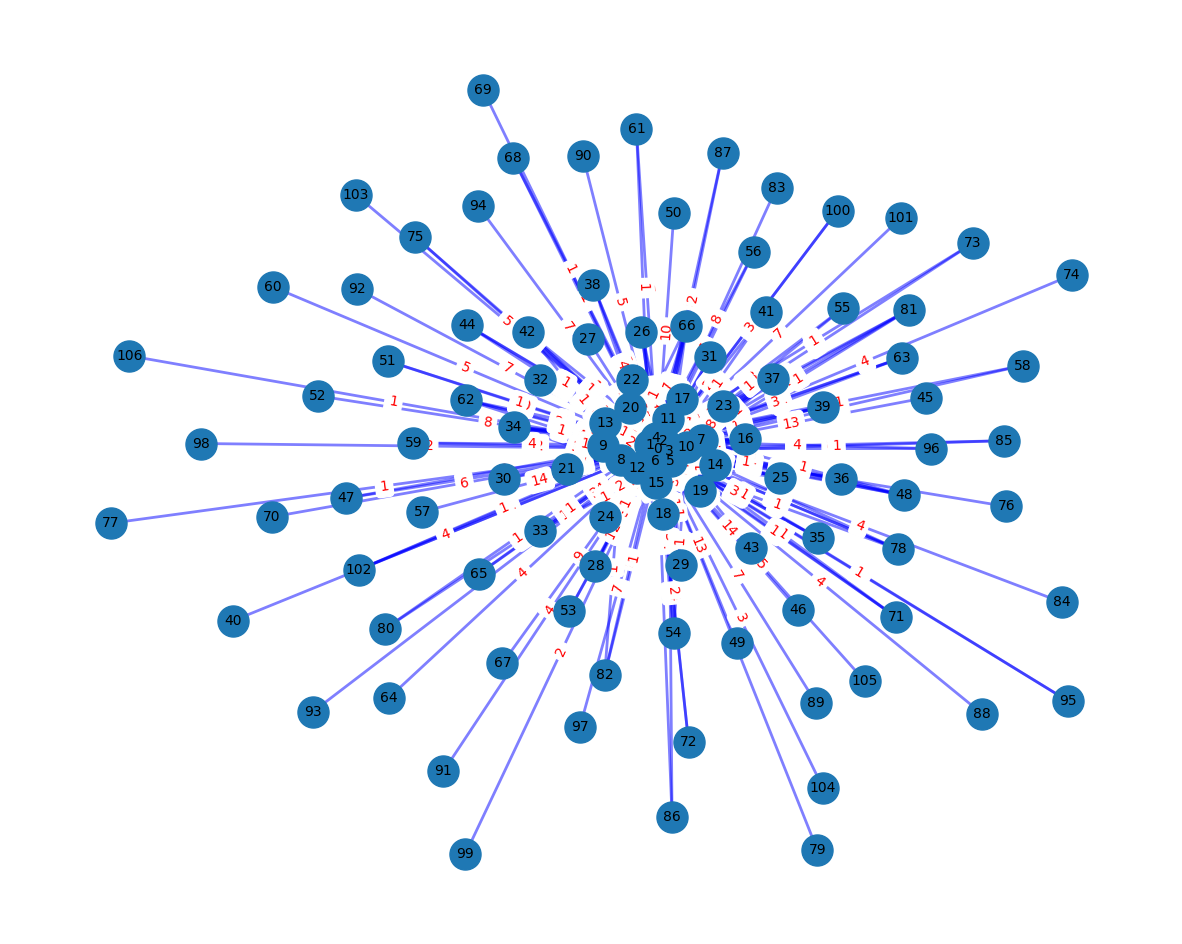

In [ ]:
infomap_graph, infomap_weight, infomap_degrees = visualize_graph(infomap_df)

In [ ]:
infomap_graph

In [ ]:
# Exportamos la información de los nodos y las aristas
nodes_df = pd.DataFrame(list(infomap_degrees.items()), columns=['node', 'size'])
nodes_df.to_csv('drive/MyDrive/TFM/infomap_nodes.csv', index=False)

edges_data = [(u, v, infomap_graph[u][v]['weight']) for u, v in infomap_graph.edges]
edges_df = pd.DataFrame(edges_data, columns=['source', 'target', 'weight_attribute'])
edges_df.to_csv('drive/MyDrive/TFM/infomap_edges.csv', index=False)

## **LPA**

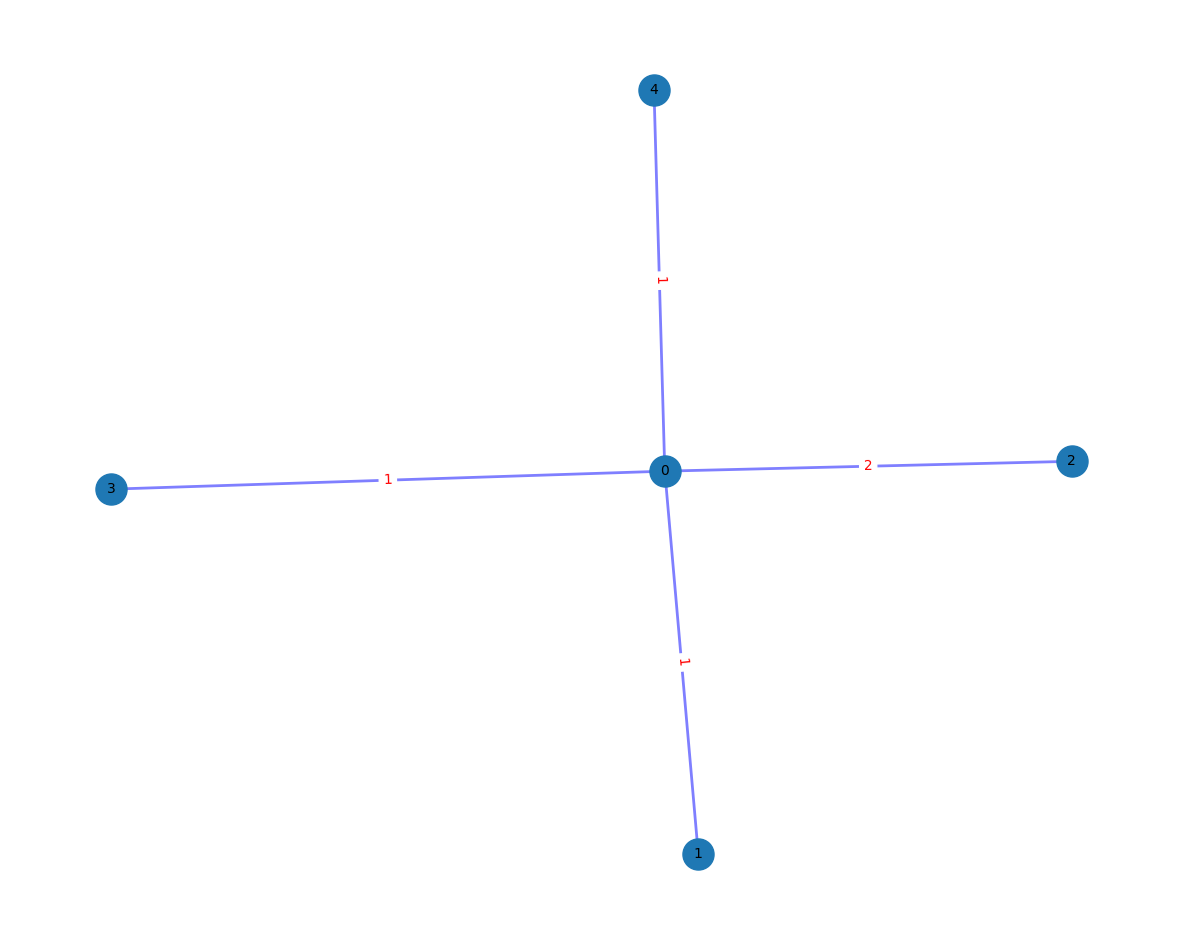

In [ ]:
lpa_graph, lpa_weight, lpa_degrees = visualize_graph(lpa_df)

In [ ]:
lpa_weight

5

In [ ]:
# Exportamos la información de los nodos y las aristas
nodes_df = pd.DataFrame(list(lpa_degrees.items()), columns=['node', 'size'])
nodes_df.to_csv('drive/MyDrive/TFM/lpa_nodes.csv', index=False)

edges_data = [(u, v, lpa_graph[u][v]['weight']) for u, v in lpa_graph.edges]
edges_df = pd.DataFrame(edges_data, columns=['source', 'target', 'weight_attribute'])
edges_df.to_csv('drive/MyDrive/TFM/lpa_edges.csv', index=False)

## **Louvain**

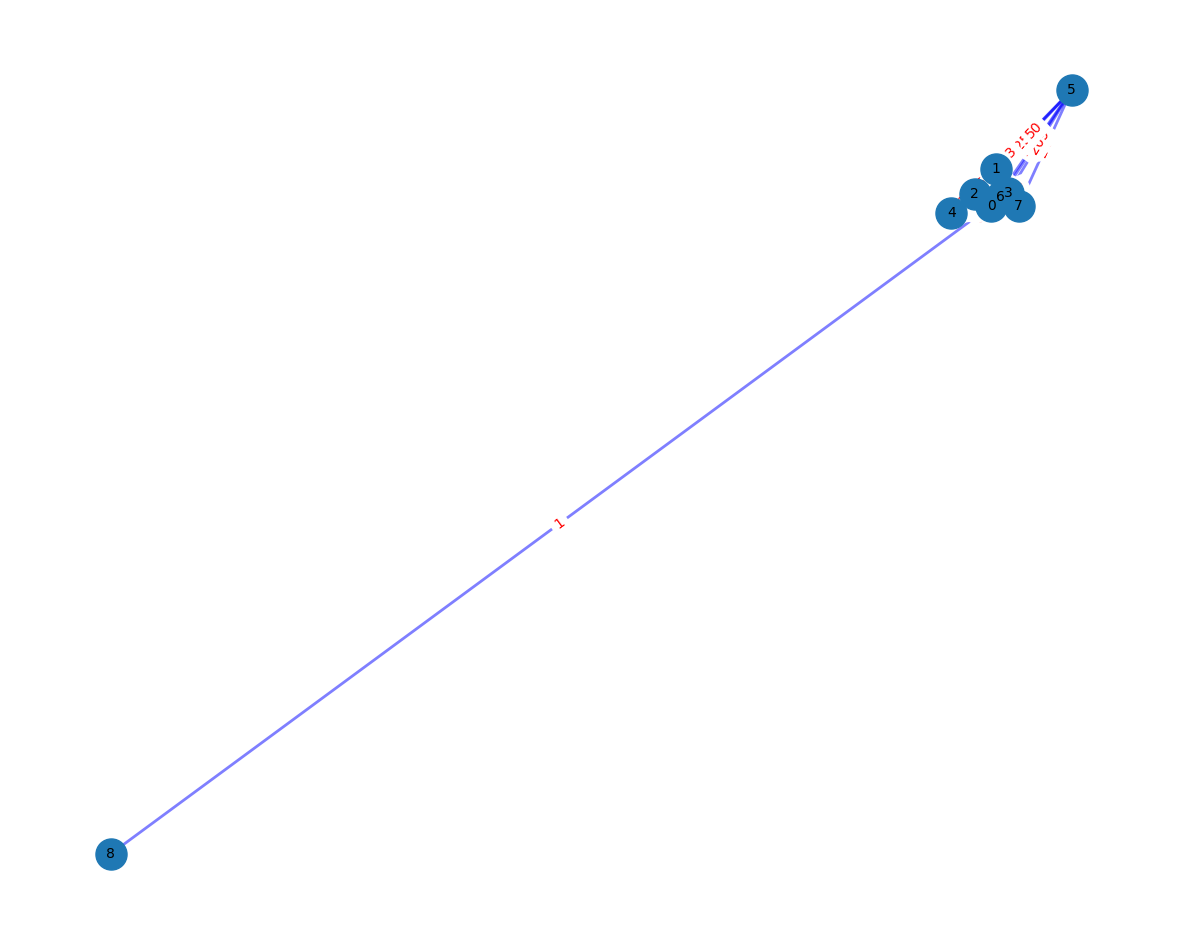

In [ ]:
louvain_graph, louvain_weight, louvain_degrees = visualize_graph(louvain_df)

In [ ]:
# Exportamos la información de los nodos y las aristas
nodes_df = pd.DataFrame(list(louvain_degrees.items()), columns=['node', 'size'])
nodes_df.to_csv('drive/MyDrive/TFM/louvain_nodes.csv', index=False)

edges_data = [(u, v, louvain_graph[u][v]['weight']) for u, v in louvain_graph.edges]
edges_df = pd.DataFrame(edges_data, columns=['source', 'target', 'weight_attribute'])
edges_df.to_csv('drive/MyDrive/TFM/louvain_edges.csv', index=False)